In [261]:
import numpy as np
import pandas as pd
import wget
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge

In [91]:
data_url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
wget.download(data_url)

'data (1).csv'

In [236]:
df = pd.read_csv("data.csv")
df.head()


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Data Preparation

In [237]:
# selecting the features as required by the business
df = df[['Make','Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [238]:
# renaming columns
# asterisk here is to unpack the list of column names
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns = [*df.columns[:-1], 'price']
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price'],
      dtype='object')

In [239]:
# filling in missing values
display(df.isnull().sum())

df.engine_hp.fillna(0, inplace=True)
df.engine_cylinders.fillna(0, inplace=True)

display(df.isnull().sum())

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
dtype: int64

In [240]:
# What is the most frequent observation (mode) for the column transmission_type?
df.mode()['transmission_type']

0    AUTOMATIC
Name: transmission_type, dtype: object

In [241]:
# What are the two features that have the biggest correlation in this dataset?

display(df.dtypes)

numerical_features = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'price']
categorical_features = ['make','model','transmission_type','vehicle_style']

# correlation matrix
df[numerical_features].corr()

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
price                  int64
dtype: object

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.000000,0.338714,-0.040708,0.258240,0.198171,0.227590
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918,0.650095
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306,0.526274
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000,-0.157676
price,0.227590,0.650095,0.526274,-0.160043,-0.157676,1.000000


<Axes: >

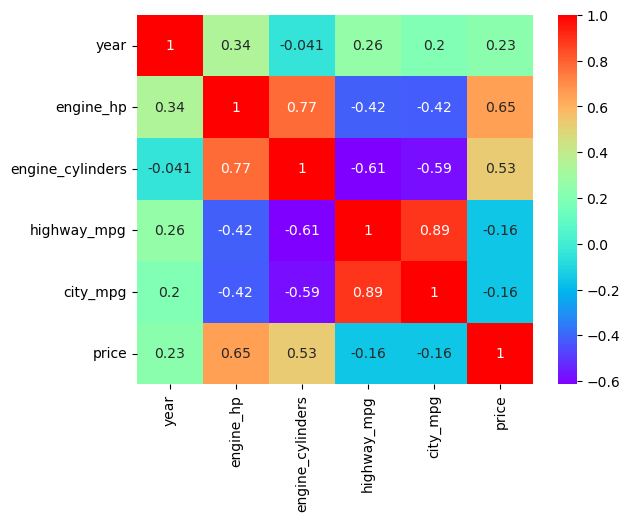

In [242]:
# correlation plot for numerical features
sns.heatmap(df[numerical_features].corr(), annot=True, cmap= 'rainbow')

highway_mpg and city_mpg have the highest correlation which is not surprising

In [243]:
# To convert this to a binary classification problem and use logistic regression, the target variable price needs to be bucketed
avg_price = df.price.mean()
display(avg_price)
df['above_average'] = df['price'].apply(lambda x: 1 if x > avg_price else 0)
df.head()


40594.737032063116

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


### Validation framework

In [244]:
# X = df[['make','model','year','engine_hp','engine_cylinders','transmission_type','vehicle_style','highway_mpg','city_mpg']]
# display(X.head())
# y = df['above_average']
# display(y.head())
       
# Split data in train/val/test sets with 60%/20%/20% distribution
# sklearn does shuffling by default. As the function only splits the data into two sets, it needs 
# to be used a second time for validation split with appropriate # test size proportion to get 60%,20%,20%
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

len(df_train), len(df_val), len(df_test)


(7148, 2383, 2383)

In [245]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [246]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

y_train_for_regression = np.log1p(df_train.price.values)
y_val_for_regression = np.log1p(df_val.price.values)
y_test_for_regression = np.log1p(df_test.price.values)

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

del df_train['price']
del df_val['price']
del df_test['price']

df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Mitsubishi,Endeavor,2011,225.0,6.0,AUTOMATIC,4dr SUV,19,15
1,Kia,Borrego,2009,276.0,6.0,AUTOMATIC,4dr SUV,21,17
2,Lamborghini,Gallardo,2012,570.0,10.0,MANUAL,Convertible,20,12
3,Chevrolet,Colorado,2016,200.0,4.0,AUTOMATIC,Crew Cab Pickup,27,20
4,Pontiac,Vibe,2009,158.0,4.0,AUTOMATIC,4dr Hatchback,26,20


Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

easy to use and interpret,
computationally efficient,
theoretically well-founded,
resistant to overfitting, and,
able to detect any kind of relationship

The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

- MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. - MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [247]:
# Which of these variables has the lowest mutual information score?
def mutual_info_price_score(series):
    return round(mutual_info_score(series, y_train),2)

df_train[categorical_features].apply(mutual_info_price_score)

make                 0.24
model                0.46
transmission_type    0.02
vehicle_style        0.08
dtype: float64

In [248]:
def mutual_info_price_score(series):
    return round(mutual_info_score(series, df_full_train.above_average.values),2)
df_full_train[categorical_features].apply(mutual_info_price_score)

make                 0.24
model                0.46
transmission_type    0.02
vehicle_style        0.08
dtype: float64

transmission_type has the least mi score and is not very useful relatively in reducing the uncertainity in our target variable

In [249]:
# one hot encoding the categorical variables to use them for logistic regression
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
display(dv.get_feature_names_out())

val_dict = df_val.to_dict(orient='records')
display(val_dict)
X_val = dv.transform(val_dict)
X_val

array(['city_mpg', 'engine_cylinders', 'engine_hp', 'highway_mpg',
       'make=Acura', 'make=Alfa Romeo', 'make=Aston Martin', 'make=Audi',
       'make=BMW', 'make=Bentley', 'make=Bugatti', 'make=Buick',
       'make=Cadillac', 'make=Chevrolet', 'make=Chrysler', 'make=Dodge',
       'make=FIAT', 'make=Ferrari', 'make=Ford', 'make=GMC',
       'make=Genesis', 'make=HUMMER', 'make=Honda', 'make=Hyundai',
       'make=Infiniti', 'make=Kia', 'make=Lamborghini', 'make=Land Rover',
       'make=Lexus', 'make=Lincoln', 'make=Lotus', 'make=Maserati',
       'make=Maybach', 'make=Mazda', 'make=McLaren', 'make=Mercedes-Benz',
       'make=Mitsubishi', 'make=Nissan', 'make=Oldsmobile',
       'make=Plymouth', 'make=Pontiac', 'make=Porsche',
       'make=Rolls-Royce', 'make=Saab', 'make=Scion', 'make=Spyker',
       'make=Subaru', 'make=Suzuki', 'make=Tesla', 'make=Toyota',
       'make=Volkswagen', 'make=Volvo', 'model=1 Series', 'model=100',
       'model=124 Spider', 'model=190-Class', 'model

[{'make': 'Volkswagen',
  'model': 'Beetle',
  'year': 2015,
  'engine_hp': 210.0,
  'engine_cylinders': 4.0,
  'transmission_type': 'MANUAL',
  'vehicle_style': '2dr Hatchback',
  'highway_mpg': 31,
  'city_mpg': 23},
 {'make': 'Audi',
  'model': 'SQ5',
  'year': 2015,
  'engine_hp': 354.0,
  'engine_cylinders': 6.0,
  'transmission_type': 'AUTOMATIC',
  'vehicle_style': '4dr SUV',
  'highway_mpg': 24,
  'city_mpg': 17},
 {'make': 'Pontiac',
  'model': 'Grand Am',
  'year': 2005,
  'engine_hp': 140.0,
  'engine_cylinders': 4.0,
  'transmission_type': 'AUTOMATIC',
  'vehicle_style': 'Sedan',
  'highway_mpg': 31,
  'city_mpg': 22},
 {'make': 'Nissan',
  'model': '350Z',
  'year': 2009,
  'engine_hp': 306.0,
  'engine_cylinders': 6.0,
  'transmission_type': 'MANUAL',
  'vehicle_style': 'Convertible',
  'highway_mpg': 24,
  'city_mpg': 17},
 {'make': 'Ford',
  'model': 'E-150',
  'year': 1996,
  'engine_hp': 199.0,
  'engine_cylinders': 6.0,
  'transmission_type': 'AUTOMATIC',
  'vehicle_

array([[2.300e+01, 4.000e+00, 2.100e+02, ..., 0.000e+00, 0.000e+00,
        2.015e+03],
       [1.700e+01, 6.000e+00, 3.540e+02, ..., 0.000e+00, 0.000e+00,
        2.015e+03],
       [2.200e+01, 4.000e+00, 1.400e+02, ..., 1.000e+00, 0.000e+00,
        2.005e+03],
       ...,
       [1.200e+01, 6.000e+00, 1.900e+02, ..., 0.000e+00, 0.000e+00,
        2.003e+03],
       [1.400e+01, 8.000e+00, 4.300e+02, ..., 0.000e+00, 0.000e+00,
        2.015e+03],
       [1.800e+01, 6.000e+00, 3.210e+02, ..., 1.000e+00, 0.000e+00,
        2.015e+03]])

### Logistic Regression

In [250]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [251]:
model.intercept_

array([-0.54930869])

In [252]:
model.coef_[0].round(3)

array([ 8.300e-02, -1.330e-01,  3.900e-02,  0.000e+00,  1.601e+00,
        2.188e+00,  7.620e-01,  3.249e+00,  2.858e+00,  2.130e-01,
        0.000e+00, -4.610e-01,  2.597e+00, -1.751e+00, -1.413e+00,
       -4.048e+00, -6.620e-01,  5.090e-01, -2.132e+00, -1.369e+00,
        8.890e-01, -3.550e-01, -1.347e+00, -2.693e+00,  3.290e-01,
       -1.526e+00,  1.500e-02,  2.173e+00,  1.507e+00,  1.224e+00,
        4.405e+00,  1.343e+00,  6.000e-03, -1.762e+00,  1.000e-03,
        9.090e-01, -2.414e+00, -1.314e+00, -1.753e+00, -6.450e-01,
       -3.691e+00,  1.956e+00,  1.274e+00,  7.200e-01, -3.000e-01,
        4.610e-01, -3.110e+00, -2.217e+00,  3.706e+00, -4.010e-01,
       -1.123e+00,  1.044e+00, -1.830e+00, -7.290e-01, -6.800e-02,
       -1.500e-02, -2.000e-03, -1.873e+00, -1.233e+00, -3.000e-03,
       -7.000e-03, -4.000e-03, -2.080e-01,  1.960e-01,  2.363e+00,
        7.270e-01, -6.570e-01, -6.900e-02, -2.310e-01, -2.810e-01,
       -0.000e+00, -2.300e-02, -1.136e+00,  2.050e-01,  6.000e

In [253]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([3.07033780e-04, 9.97720253e-01, 6.97938861e-05, ...,
       1.01043039e-04, 9.91013704e-01, 9.90912809e-01])

In [254]:
above_average_price_decision = (y_pred >= 0.5)

# accuracy on validation dataset
display(round((y_val == above_average_price_decision).mean(),2))
original_accuracy = round((y_val == above_average_price_decision).mean(),2)

0.95

In [255]:
# A function to replicate the steps above with either logistic regression for above_average binary target
# or ridge regression for numerical price prediction
def ohe_fit_and_predict(df_training, df_validation, model_choice, alpha = 0):

    #print("training on : ", df_training.dtypes)
    
    # convert to dict
    train_dict = df_training.to_dict(orient='records')
    
    # one hot encoding
    X_train = dv.fit_transform(train_dict)
    
    # convert to dict
    val_dict = df_validation.to_dict(orient='records')
    
    # one hot encoding
    X_val = dv.transform(val_dict)
    
    if model_choice == "logistic regression":
        # fit logistic regression
        model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        # get predictions
        y_pred = model.predict_proba(X_val)[:, 1]
    else:
        # fit ridge regression
        model = Ridge(solver='sag', alpha = alpha, random_state=42)
        model.fit(X_train, y_train_for_regression)
        # get predictions
        y_pred = model.predict(X_val)
    
    return y_pred

### Feature Elimination

In [256]:
results = []

# Eliminating one feature at a time
for i in range(len(df_train.columns)):

    temp_train = df_train.copy()
    temp_val = df_val.copy()

    feature_eliminated = temp_train.columns[[i]]
    
    # drop the feature from both train and val datasets
    temp_train = temp_train.drop(feature_eliminated, axis = 1)
    temp_val = temp_val.drop(feature_eliminated, axis = 1)

    # apply one hot coding, fit logistic regression and get prediction
    y_pred = ohe_fit_and_predict(temp_train, temp_val, model_choice="logistic regression")

    above_average_price_decision = (y_pred >= 0.5)
    # accuracy on validation dataset
    accuracy = (y_val == above_average_price_decision).mean()

    # difference between original accuracy (full model) and accuracy when a feature is eliminated
    difference_in_accuracies = abs(original_accuracy - accuracy)

    print(feature_eliminated, ": accuracy = ", accuracy," difference in accuracy = ",difference_in_accuracies)
    
    results.append([feature_eliminated, difference_in_accuracies])



Index(['make'], dtype='object') : accuracy =  0.9492236676458246  difference in accuracy =  0.0007763323541754019
Index(['model'], dtype='object') : accuracy =  0.9240453210239195  difference in accuracy =  0.025954678976080503
Index(['year'], dtype='object') : accuracy =  0.9479647503147294  difference in accuracy =  0.0020352496852705793
Index(['engine_hp'], dtype='object') : accuracy =  0.9303399076793957  difference in accuracy =  0.019660092320604283
Index(['engine_cylinders'], dtype='object') : accuracy =  0.9471254720939991  difference in accuracy =  0.0028745279060008455
Index(['transmission_type'], dtype='object') : accuracy =  0.9450272765421738  difference in accuracy =  0.004972723457826178
Index(['vehicle_style'], dtype='object') : accuracy =  0.9425094418799832  difference in accuracy =  0.007490558120016755
Index(['highway_mpg'], dtype='object') : accuracy =  0.9441879983214435  difference in accuracy =  0.005812001678556444
Index(['city_mpg'], dtype='object') : accuracy

In [257]:
results_df = pd.DataFrame(results, columns=['feature', 'difference_in_accuracy'])
results_df.sort_values(by='difference_in_accuracy')


,feature,difference_in_accuracy
0,"Index(['make'], dtype='object')",0.000776
2,"Index(['year'], dtype='object')",0.002035
4,"Index(['engine_cylinders'], dtype='object')",0.002875
8,"Index(['city_mpg'], dtype='object')",0.004133
5,"Index(['transmission_type'], dtype='object')",0.004973
7,"Index(['highway_mpg'], dtype='object')",0.005812
6,"Index(['vehicle_style'], dtype='object')",0.007491
3,"Index(['engine_hp'], dtype='object')",0.019660
1,"Index(['model'], dtype='object')",0.025955


### Ridge Regression: For an alternate usecase when predicting just above_average is insufficient and need exact price prediction  

Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

Loss function = OLS + alpha * summation (squared coefficient values)

In the above loss function, alpha is the parameter we need to select. A low alpha value can lead to over-fitting, whereas a high alpha value can lead to under-fitting.

In [262]:
alpha_choice_list = [0, 0.01, 0.1, 1, 10]
rmse_list = []

for r in alpha_choice_list:
    
    # one hot encoding, fitting ridge regression with a learning parameter choice (alpha/r) and getting predictions
    y_pred = ohe_fit_and_predict(df_training = df_train, df_validation = df_val, model_choice = 'ridge regression', alpha = r)
    
    # calculating RMSE 
    rmse = round(np.sqrt(mean_squared_error(y_true=y_val_for_regression, y_pred=y_pred)),3)
    
    print(r, rmse)
    print(r2_score(y_val_for_regression, y_pred))
    # append alpha parameter and it's corresponding RMSE
    rmse_list.append([r, rmse])



c:\Users\avanjavakam\.conda\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0 0.487
0.8141541190668431


c:\Users\avanjavakam\.conda\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.01 0.487
0.8141539368187797


c:\Users\avanjavakam\.conda\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.1 0.487
0.8141522966392726


c:\Users\avanjavakam\.conda\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1 0.487
0.8141358993257886
10 0.487
0.8139723726362196


c:\Users\avanjavakam\.conda\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [263]:
rmse_list

[[0, 0.487], [0.01, 0.487], [0.1, 0.487], [1, 0.487], [10, 0.487]]